In [155]:
import torch
import torch.nn as nn
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage.filters import gaussian

In [156]:
def gaussian_blur(img, sigma):
    """Returns the Gaussian blurred version of the image 'img' with a sigma value of 'sigma'"""
    return np.array(gaussian(img, (sigma, sigma)))

def gaussian_blur_arr(images,sigma):
  """Applies the function gaussian_blur to all images in the set 'images'"""
  a = []
  for img in images:
    a.append(gaussian_blur(img,sigma))
  return np.array(a)

def norm_max_pixel(images):
  """Normalizes each image in the array 'images' such that the pixel intensities are within a range of 0 to 1"""
  a = []
  for img in images:
    img = img/np.max(img)
    a.append(img)
  return np.array(a)

def preprocess_images(images, size, sigma):
    """Preprocesses each image in the array 'images' applying the proper blurring, normalization, and shape to each image"""
    images = gaussian_blur_arr(images, sigma)
    images = norm_max_pixel(images)
    images = images.reshape((images.shape[0], 1, size, size))
    return torch.from_numpy(images.astype('float32')) #! the change from original code: images.astype('float32') 

# TODO : potential problem
def get_predictions_from_model(model, images):
    """Returns an array of images 'prd' containing the prediction of each image in the input array 'images' from the CVAE model 'model'"""
    with torch.no_grad():
        prd = model(images)[0].cpu().numpy()
    return prd[:, :, :]

def get_difference(images, prd):
    """Returns an array of images containing the difference of each image in the input array 'images' with its respective prediction
    of the model in the input array 'prd'"""
    return images[:, 0, :, :] - prd

def get_heatmap(images):
    """set all pixels with an absolute value lower than MAX_PIXEL to 0"""
    return np.where(abs(images) < MAX_PIXEL, 0, images)

def get_avg_near_max(images):
    """Returns the average pixel intensity in an area of about a column size around the pixel with largest absolute value"""
    a = []
    for img in images:
        xmax, ymax = np.unravel_index(np.argmax(abs(img), axis=None), img.shape)
        s = 0
        c = 0
        for i in range(-CLMN_SIZE, CLMN_SIZE+1):
            for j in range(-CLMN_SIZE, CLMN_SIZE+1):
                try:
                    s += img[xmax+i][ymax+j]
                    c += 1
                except IndexError:
                    pass
        a.append(s / c)
    return np.array(a)

def plot_ANM(images, Labels=[], width=15, height=15, xmin=-0.4, xmax=0.4, legend_loc=(.5, .75), legend_size="xx-large", limit_coefficient=1.5):
    """plots the histograms of given arrays and calculates percentage within 1.5*std of the bulk(last array given)"""
    fig = plt.figure(figsize=(width, height))
    if not Labels:
        Labels = np.arange(len(images))
    maxL = np.max([len(i) for i in Labels])

    i = 0
    bmin = images[-1].mean() - limit_coefficient * images[-1].std()
    bmax = images[-1].mean() + limit_coefficient * images[-1].std()
    if images[-1].std() == 0:
        bmin = -0.1
        bmax = 0.1
    ymax = 1
    tot_prob_finding_defects = 0

    for img in images:
        p = np.logical_and(img > bmin, img < bmax).sum() / len(img)
        if i < len(images) - 1:
            p = 100 - 100 * p
        else:
            p = 100 * p
        label = Labels[i] + " Detected " + " " * (maxL - len(Labels[i])) + " : {:.1f}%".format(p, 1 - p)
        print(label)
        y, x = plt.hist(img.flatten(), 100, (xmin, xmax), label=label)[:2]
        if np.max(y) > ymax:
            ymax = np.max(y)
        if i < len(images) - 1:
            tot_prob_finding_defects += p
        i += 1

    legend = fig.legend(loc=legend_loc, fontsize=legend_size, edgecolor="white")
    plt.plot([bmin, bmin], [0, ymax], 'k--', linewidth=1)
    plt.plot([bmax, bmax], [0, ymax], 'k--', linewidth=1)
    print("Total Probability of finding a defect image = {:.3f}".format(tot_prob_finding_defects / (len(images) - 1)))

In [157]:
SIZE = 64
CLMN_SIZE = 6
IMAGE_NAME = "20111206DF"
set_name = "20111206DF"
path = ""
SIGMA = 2
epochs = 200
latent_dim = 20

In [158]:
# Load the previously created sets
bulk_images = np.load(path + "data/" + "raw_testing_set_" + set_name + "_64.npy")
antiTi_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_antiTi_defect_64.npy")
antiSr_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_antiSr_defect_64.npy")
SrVacancy_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_SrVacancy_defect_64.npy")
TiVacancy_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_TiVacancy_defect_64.npy")
SrFMag_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_SrFMag_defect_64.npy")
TiFMag_defect_images = np.load(path + "data/defects_2D/" + set_name + "raw_TiFMag_defect_64.npy")

In [159]:
# Preprocess each set to apply the CVAE model
bulk_images = preprocess_images(bulk_images, SIZE, SIGMA)
antiSr_defect_images = preprocess_images(antiSr_defect_images, SIZE, SIGMA)
antiTi_defect_images = preprocess_images(antiTi_defect_images, SIZE, SIGMA)
TiVacancy_defect_images = preprocess_images(TiVacancy_defect_images, SIZE, SIGMA)
SrVacancy_defect_images = preprocess_images(SrVacancy_defect_images, SIZE, SIGMA)
SrFMag_defect_images = preprocess_images(SrFMag_defect_images, SIZE, SIGMA)
TiFMag_defect_images = preprocess_images(TiFMag_defect_images, SIZE, SIGMA)

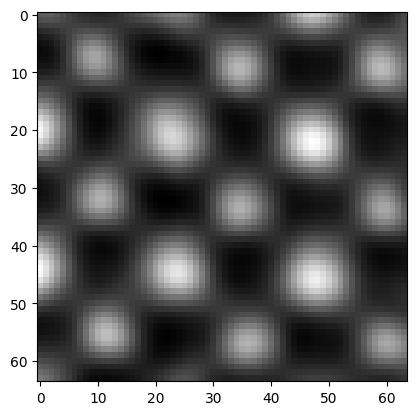

In [172]:
class CVAE(nn.Module):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim, size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.size = size
        reduced_size = size // 8
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * reduced_size * reduced_size, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, reduced_size * reduced_size * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, reduced_size, reduced_size)),
            nn.ConvTranspose2d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = torch.chunk(h, 2, dim=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = torch.sigmoid(logits)
            return probs
        return logits

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

# Load the state dictionary
state_dict = torch.load(path + 'data/models/' + '20111206DF_Size64_SIGMA2_epochs200_latentdim20.pth')

# Create an instance of the CVAE model
latent_dim = 20  
model = CVAE(latent_dim, SIZE)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

plt.imshow(bulk_images[0][0], cmap='gray')

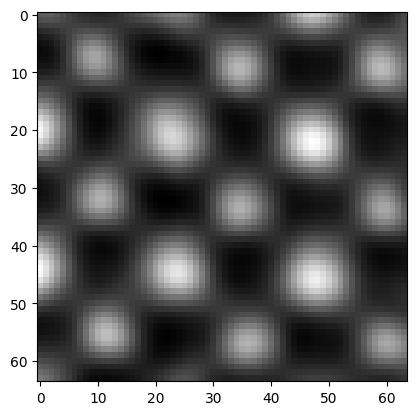

In [176]:
bulk_prd = get_predictions_from_model(model, bulk_images)
# antiTi_defect_prd = get_predictions_from_model(model, antiTi_defect_images)
# antiSr_defect_prd = get_predictions_from_model(model, antiSr_defect_images)
# TiVacancy_defect_prd = get_predictions_from_model(model, TiVacancy_defect_images)
# SrVacancy_defect_prd = get_predictions_from_model(model, SrVacancy_defect_images)
# TiFMag_defect_prd = get_predictions_from_model(model, TiFMag_defect_images)
# SrFMag_defect_prd = get_predictions_from_model(model, SrFMag_defect_images)

plt.imshow(bulk_prd[0], cmap='gray')
plt.imshow(bulk_images[0][0], cmap='gray')

In [162]:
# Get the difference (input - prediction) for each set
bulk_diff = get_difference(bulk_images, bulk_prd)
antiSr_defect_diff = get_difference(antiSr_defect_images, antiSr_defect_prd)
antiTi_defect_diff = get_difference(antiTi_defect_images, antiTi_defect_prd)
SrVacancy_defect_diff = get_difference(SrVacancy_defect_images, SrVacancy_defect_prd)
TiVacancy_defect_diff = get_difference(TiVacancy_defect_images, TiVacancy_defect_prd)
TiFMag_defect_diff = get_difference(TiFMag_defect_images, TiFMag_defect_prd)
SrFMag_defect_diff = get_difference(SrFMag_defect_images, SrFMag_defect_prd)

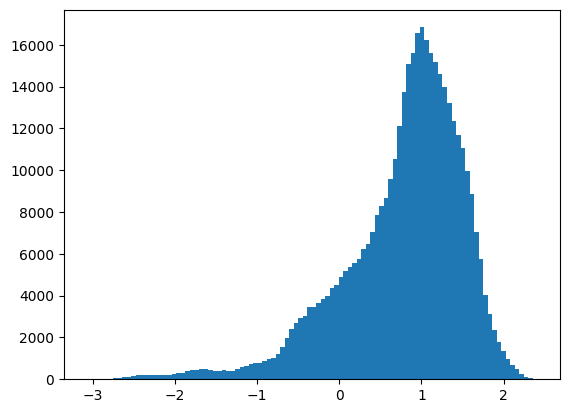

In [163]:
#Plot the pixels' intenisty distribution for the bulk samples
y, x = plt.hist(bulk_diff.flatten(), 100)[:2]

In [168]:
# Set MAX_PIXEL based on plot above
MAX_PIXEL = 1.0 # Describes the largest absolute value of pixel intensity in a bulk difference image

In [169]:
#Obtain a heatmap for each difference image, ignoring all pixels of magnitude lower than MAX_PIXEL
bulk_heatmap = get_heatmap(bulk_diff)
antiSr_defect_heatmap = get_heatmap(antiSr_defect_diff)
antiTi_defect_heatmap = get_heatmap(antiTi_defect_diff)
SrVacancy_defect_heatmap = get_heatmap(SrVacancy_defect_diff)
TiVacancy_defect_heatmap = get_heatmap(TiVacancy_defect_diff)
TiFMag_defect_heatmap = get_heatmap(TiFMag_defect_diff)
SrFMag_defect_heatmap = get_heatmap(SrFMag_defect_diff)

Anti Sr site Detected      : 95.0%
Sr Vacancy Detected        : 16.4%
Ferroelectric Sr Detected  : 15.8%
Anti Ti site Detected      : 19.8%
Ti Vacancy Detected        : 82.6%
Ferroelectric Ti Detected  : 15.6%
Bulk Detected              : 87.0%
Total Probability of finding a defect image = 40.867


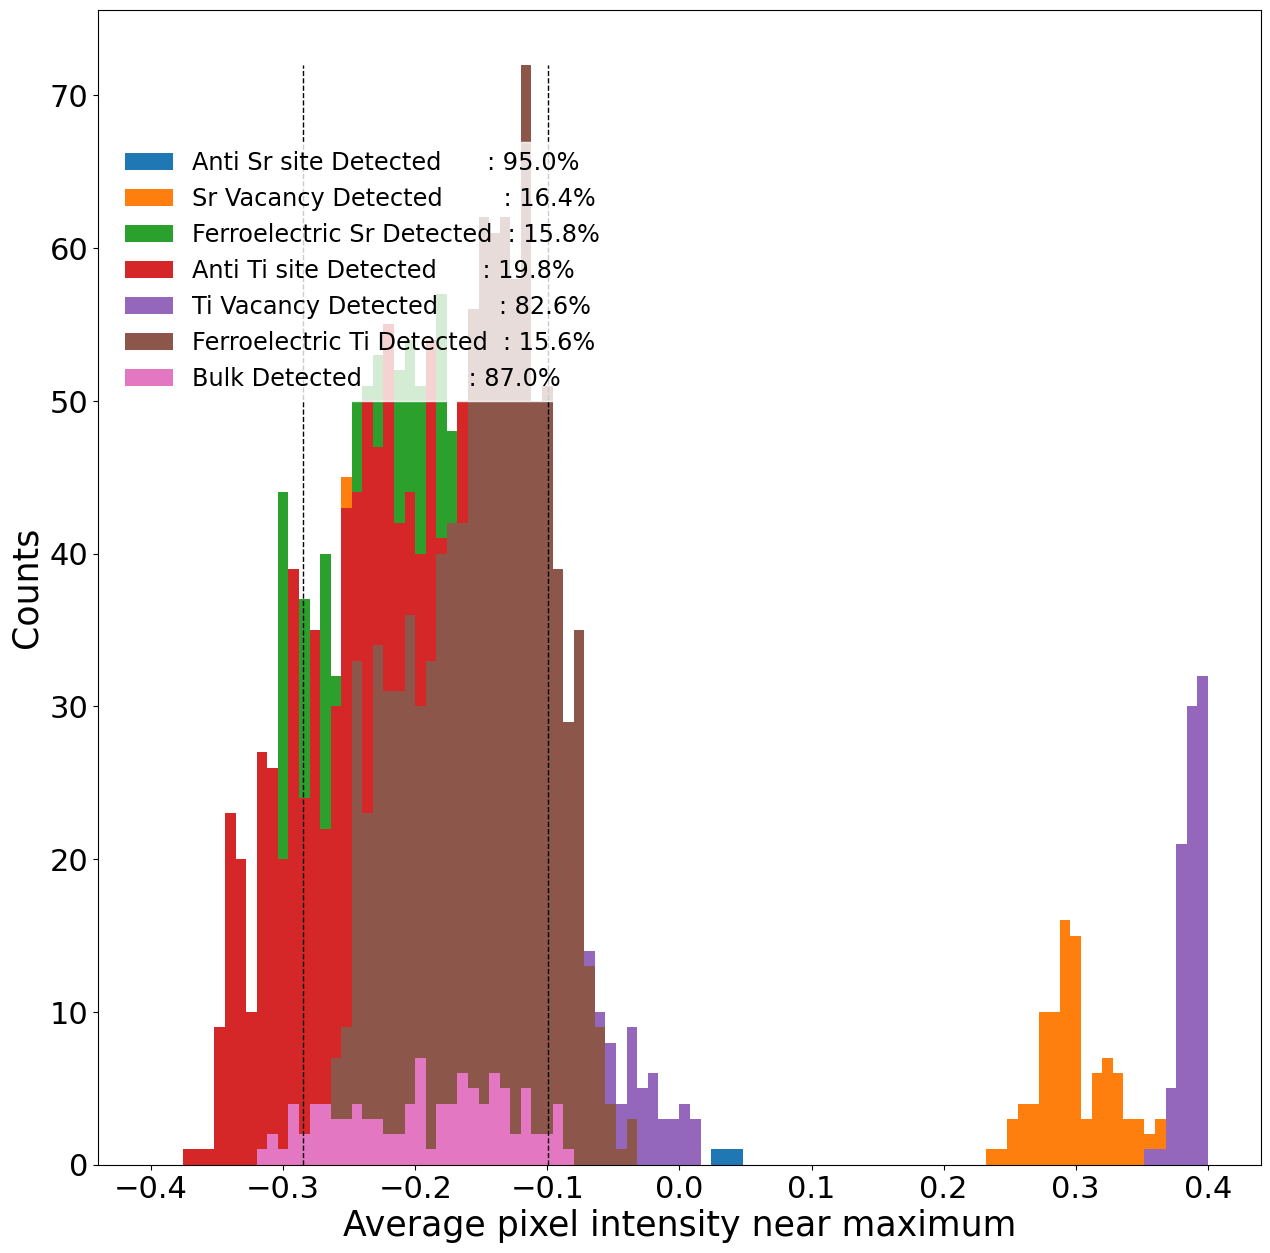

In [170]:
#Plot the distribution of the average near maximum for each set and the respective percentage of correctly labled images
plot_ANM([get_avg_near_max(antiSr_defect_heatmap),get_avg_near_max(SrVacancy_defect_heatmap), get_avg_near_max(SrFMag_defect_heatmap), 
                     get_avg_near_max(antiTi_defect_heatmap),get_avg_near_max(TiVacancy_defect_heatmap),get_avg_near_max(TiFMag_defect_heatmap),get_avg_near_max(bulk_heatmap)],
                    Labels=["Anti Sr site","Sr Vacancy","Ferroelectric Sr",
                            "Anti Ti site","Ti Vacancy","Ferroelectric Ti","Bulk"],
                    legend_loc=(0.091,0.68),limit_coefficient=1.5,xmax=0.4,xmin=-0.4)
plt.xlabel("Average pixel intensity near maximum",fontsize=25)
plt.ylabel("Counts", fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig(path+"Average pixel intensity near maximum.svg")

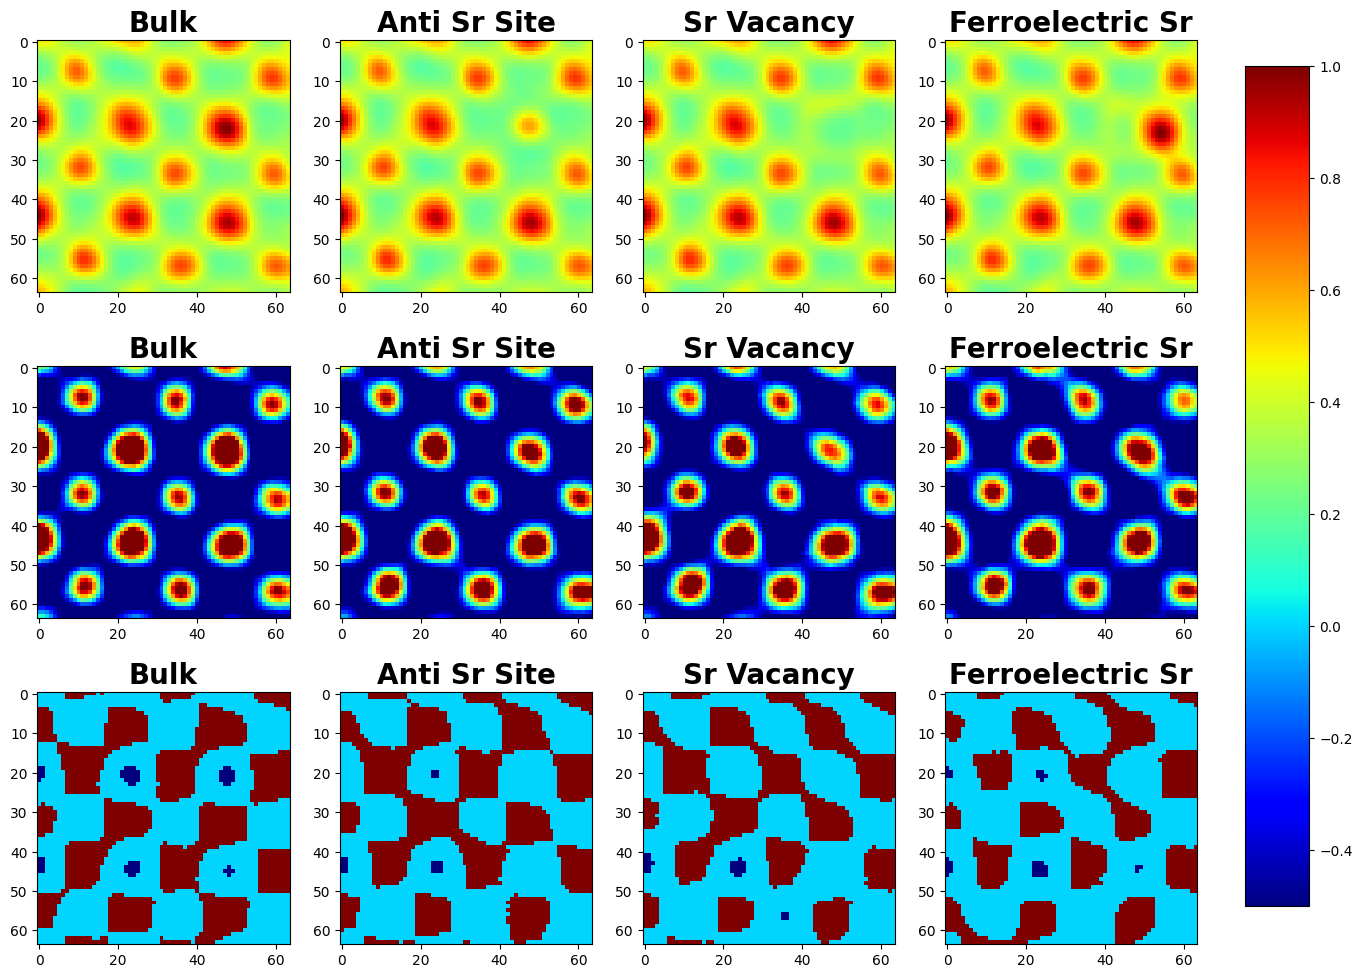

In [171]:
def plot_example(N=1, columns=4, rows=3, cmap='jet', size=(16, 12),
                 Labels=["Bulk", "Anti Sr Site", "Sr Vacancy", "Ferroelectric Sr"], Title="title"):

    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=size)

    row_labels = ["Input", "Prediction", "Difference Heatmap"]

    input_data = np.array([bulk_images[N], antiSr_defect_images[N], SrVacancy_defect_images[N], SrFMag_defect_images[N]])
    preds = np.array([bulk_prd[N], antiSr_defect_prd[N], SrVacancy_defect_prd[N], SrFMag_defect_prd[N]])
    diff = np.array([bulk_diff[N], antiSr_defect_diff[N], SrVacancy_defect_diff[N], SrFMag_defect_diff[N]])

    input_data = input_data[:, 0, :, :]  # Remove the extra dimension from input_data
    preds = preds[:, :, :]  # Remove the extra dimension from preds
    diff_heatmap = get_heatmap(diff)

    images = np.concatenate((input_data, preds, diff_heatmap))

    if len(images) < rows * columns:
        raise ValueError("too many rows and columns")

    minmin = -0.5
    maxmax = 1

    for i in range(rows):
        for j in range(columns):
            im1 = axes[i][j].imshow(images[i * columns + j], vmin=minmin, vmax=maxmax, cmap=cmap)
            axes[i][j].set_title(Labels[j], fontsize=20, fontweight='bold')

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(im1, cax=cbar_ax)

plot_example(N=0, Labels=["Bulk", "Anti Sr Site", "Sr Vacancy", "Ferroelectric Sr"], Title="Bulk")